<a href="https://colab.research.google.com/github/Datasci266-Final-Project/Job-Listings/blob/main/Analysis%20Notebooks/Model_3b_Jobbert_Testing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install transformers==4.37.2 --quiet
!pip install -U imbalanced-learn --quiet

In [ ]:
#@title Imports
import pandas as pd

import numpy as np
import random
import torch

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import re
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFXLMRobertaModel #"FacebookAI/xlm-roberta-base"

from transformers import logging
logging.set_verbosity_error()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Set seed to 10

seed_value = 10

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/DataSci 266 Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1V3QooLePiHR_DaZhbXQhsjmP1Ez5fv5F/DataSci 266 Project


In [ ]:
# Dictionaries
level_key = {
    "student_intern": 0,
    "entry": 1,
    "junior": 2,
    "mid": 3,
    "senior": 4,
    "executive": 5,
    np.nan: -1
}

# Define salary_key dictionary
# salary_key = {
#     "<45k": 0,
#     "45-65k": 1,
#     "65-85k": 2,
#     "85-110k": 3,
#     "110-150k": 4,
#     "150-200k": 5,
#     ">200k": 6,
#     np.nan: -1
# }

salary_key = {
    "<50k": 0,
    "50-100k": 1,
    "100-150k": 2,
    "150-200k": 3,
    ">200k": 4,
    np.nan: -1
}

In [ ]:
#@title Import pickle files


#import tokenized inputs for each model
with open(r'Model Objects/Tokenized Inputs: Bert Base/test_inputs_bert.pickle', 'rb') as handle:
    bert_base_test_inputs = pickle.load(handle)




# import data
with open(r'Model Objects/model_2_test_data.pickle', 'rb') as handle:
    test_data = pickle.load(handle)


# import labels
with open(r'Model Objects/Labels/model_2_labels_level_test.pickle', 'rb') as handle:
    test_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/model_2_labels_salary_test.pickle', 'rb') as handle:
    test_salary_labels = pickle.load(handle)






In [ ]:
MAX_SEQUENCE_LENGTH = 512

In [ ]:
#@title Define JobBert Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_bert_multi_output_model(bert_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=6,
                                 base_hidden_size=200,
                                  level_hidden_size=200,
                                  salary_hidden_size=200,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    bert_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]  # Extract CLS token
    pooler_token = bert_out[1]

    # base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    # base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_2')(base_hidden)
    # base_out = tf.keras.layers.Dropout(dropout, name='base_dropout_1')(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(cls_token)
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_2')(level_hidden)
    level_hidden = tf.keras.layers.Dropout(dropout, name='level_dropout_1')(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(cls_token)
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_2')(salary_hidden)
    salary_hidden = tf.keras.layers.Dropout(dropout, name='salary_dropout_1')(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
#@title Define JobBert 2 Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_bert_multi_output_model_2(bert_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=6,
                                 base_hidden_size=200,
                                  level_hidden_size=200,
                                  salary_hidden_size=200,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    bert_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]  # Extract CLS token
    pooler_token = bert_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_2')(base_hidden)
    base_out = tf.keras.layers.Dropout(dropout, name='base_dropout_1')(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_hidden)
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_2')(level_hidden)
    level_hidden = tf.keras.layers.Dropout(dropout, name='level_dropout_1')(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_hidden)
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_2')(salary_hidden)
    salary_hidden = tf.keras.layers.Dropout(dropout, name='salary_dropout_1')(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
# bert base model from pre-saved weights
jobbert_model = TFBertModel.from_pretrained('jjzha/jobbert-base-cased')
jobbert_model = create_bert_multi_output_model(jobbert_model)

jobbert_model.load_weights('./Model Objects/model_3_jobbert/model_3_jobbert_weights')

jobbert_model_2 = TFBertModel.from_pretrained('jjzha/jobbert-base-cased')
jobbert_model_2 = create_bert_multi_output_model_2(jobbert_model_2)

jobbert_model_2.load_weights('./Model Objects/model_3b_jobbert/model_3b_jobbert_weights')

In [ ]:
jobbert_model_3 = TFBertModel.from_pretrained('jjzha/jobbert-base-cased')
jobbert_model_3 = create_bert_multi_output_model_2(jobbert_model_3)

jobbert_model_3.load_weights('./Model Objects/model_3b_jobbert_5_epochs/model_3b_jobbert_weights')

In [ ]:
#set target level names and target salary names
target_names = ["student_intern", "entry", "junior", "mid", "senior", "executive"]
target_salary_names = ["<50k",
    "50-100k",
    "100-150k",
    "150-200k",
    ">200k"]




In [ ]:
predictions_jobbert = jobbert_model.predict(bert_base_test_inputs)
predictions_jobbert_2 = jobbert_model_2.predict(bert_base_test_inputs)



440/440 [==============================] - 172s 385ms/step


In [ ]:
predictions_jobbert_3 = jobbert_model_3.predict(bert_base_test_inputs)

440/440 [==============================] - 172s 385ms/step


In [ ]:
level_predictions_jobbert = tf.argmax(predictions_jobbert[0], axis=-1)
salary_predictions_jobbert = tf.argmax(predictions_jobbert[1], axis=-1)

level_predictions_jobbert_2 = tf.argmax(predictions_jobbert_2[0], axis=-1)
salary_predictions_jobbert_2 = tf.argmax(predictions_jobbert_2[1], axis=-1)



In [ ]:
level_predictions_jobbert_3 = tf.argmax(predictions_jobbert_3[0], axis=-1)
salary_predictions_jobbert_3 = tf.argmax(predictions_jobbert_3[1], axis=-1)

In [ ]:
test_level_labels = test_level_labels.apply(lambda x: 6 if x == -1 else x)


In [ ]:
test_level_analysis_df = pd.DataFrame(test_level_labels)
test_level_analysis_df.columns = ["test_level"]
test_level_analysis_df["level_predictions_jobbert"] = level_predictions_jobbert
test_level_analysis_df["level_predictions_jobbert_2"] = level_predictions_jobbert_2
test_level_analysis_df["level_predictions_jobbert_3"] = level_predictions_jobbert_3
test_level_analysis_df = test_level_analysis_df[test_level_analysis_df["test_level"] != 6]

In [ ]:
sum(test_level_analysis_df['test_level'].isnull())

0

In [ ]:
# bert base levels confusion matrix
cm = tf.math.confusion_matrix(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_jobbert'])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 3: JobBERT - Level')

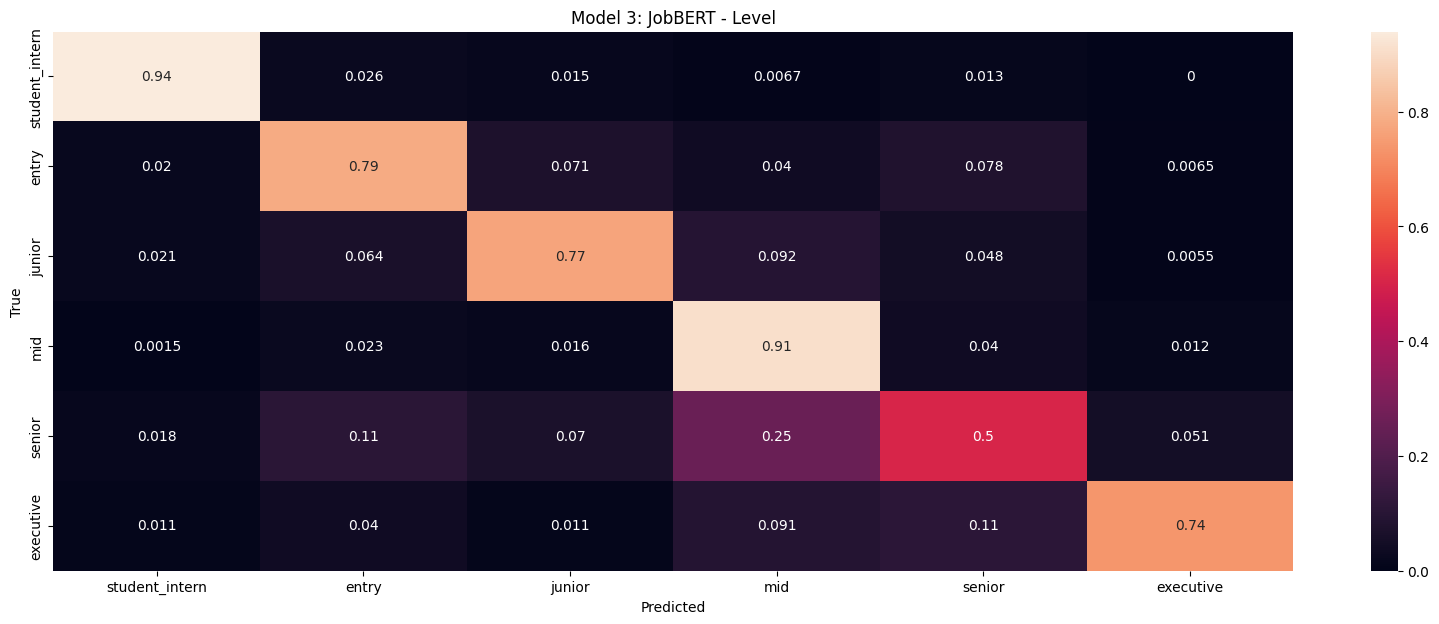

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 3: JobBERT - Level")

In [ ]:
test_salary_labels = test_salary_labels.apply(lambda x: 5 if x == -1 else x)

In [ ]:
test_salary_labels.value_counts()

salary_labels
5    11770
1     1133
0      722
2      267
4       88
3       83
Name: count, dtype: int64

In [ ]:
test_salary_analysis_df = pd.DataFrame(test_salary_labels)
test_salary_analysis_df.columns = ["test_salary"]
test_salary_analysis_df["salary_predictions_jobbert"] = salary_predictions_jobbert
test_salary_analysis_df["salary_predictions_jobbert_2"] = salary_predictions_jobbert
test_salary_analysis_df["salary_predictions_jobbert_3"] = salary_predictions_jobbert_3
test_salary_analysis_df = test_salary_analysis_df[test_salary_analysis_df["test_salary"] != 5]

In [ ]:
sum(test_salary_analysis_df['test_salary'].isnull())

0

In [ ]:
cm = tf.math.confusion_matrix(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_jobbert'])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 3: JobBERT - Salary')

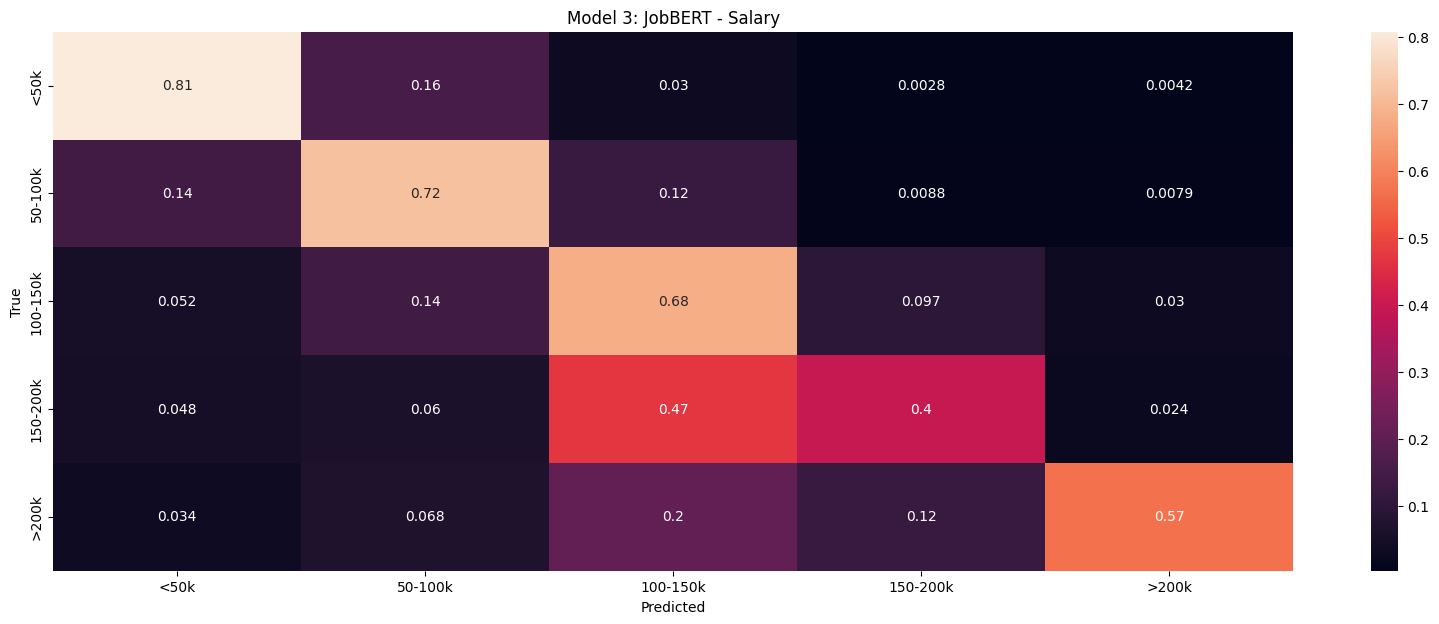

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 3: JobBERT - Salary")

In [ ]:
# calculate adjusted salary accuracy for bert base
print("Model 3: JobBERT Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 5)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_jobbert.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 3: JobBERT Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.11818246462348006
% Salary predictions incorrect: 0.88181753537652
Adjusted Salary Accuracy: 0.7248146532926297


In [ ]:
# calculate adjusted level accuracy for bert base
print("Model 3: JobBERT Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_jobbert.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 3: JobBERT Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.5923344947735192
% Level predictions incorrect: 0.4076655052264808
Adjusted Level Accuracy: 0.677125670622663


In [ ]:
print('Model 3: JobBERT - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_jobbert'], target_names=target_names))

print('')
print('-'*20)
print('')

print('Model 3: JobBERT - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_jobbert'], target_names=target_salary_names))

print('')
print('='*20)
print('')

print('Model 3: JobBERT 2 - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_jobbert_2'], target_names=target_names))


print('')
print('-'*20)
print('')

print('Model 3: JobBERT 2 - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_jobbert_2'], target_names=target_salary_names))


print('')
print('='*20)
print('')

print('Model 3: JobBERT 3 - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_jobbert_3'], target_names=target_names))


print('')
print('-'*20)
print('')

print('Model 3: JobBERT 3 - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_jobbert_3'], target_names=target_salary_names))



Model 3: JobBERT - Level Classification Metrics
                precision    recall  f1-score   support

student_intern       0.80      0.94      0.86       743
         entry       0.67      0.79      0.72      1991
        junior       0.65      0.77      0.71      1450
           mid       0.51      0.91      0.65      1989
        senior       0.90      0.50      0.64      5855
     executive       0.37      0.74      0.49       274

      accuracy                           0.68     12302
     macro avg       0.65      0.77      0.68     12302
  weighted avg       0.75      0.68      0.68     12302


--------------------

Model 3: JobBERT - Salary Classification Metrics
              precision    recall  f1-score   support

        <50k       0.76      0.81      0.78       722
     50-100k       0.84      0.72      0.77      1133
    100-150k       0.45      0.68      0.54       267
    150-200k       0.40      0.40      0.40        83
       >200k       0.69      0.57      0.62   